## 2. Stereo Vision

### 2.1. Depth Estimation from Stereo Images

In [1]:
import re
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from struct import *

In [2]:
def readPFM(file):
    with open(file, 'rb') as f:
        # Line 1: PF=>RGB (3 channels), Pf=>Greyscale (1 channel)
        type = f.readline().decode('latin-1')
        if 'PF' in type:
            channels = 3
        elif 'Pf' in type:
            channels = 1
        else:
            sys.exit(1)

        # Line 2: width height
        line = f.readline().decode('latin-1')
        width, height = map(int, re.findall(r'\d+', line))

        # Line 3: positive number means big endian, negative means little endian
        line = f.readline().decode('latin-1')
        BigEndian = not '-' in line
        # Slurp all binary data
        samples = width * height * channels
        buffer = f.read(samples * 4)
        # Unpack floats with appropriate endianness
        fmt = ('>' if BigEndian else '<') + str(samples) + 'f'
        img = np.flipud(np.array(unpack(fmt, buffer)).reshape(height, width))
    return img.astype(np.uint8)

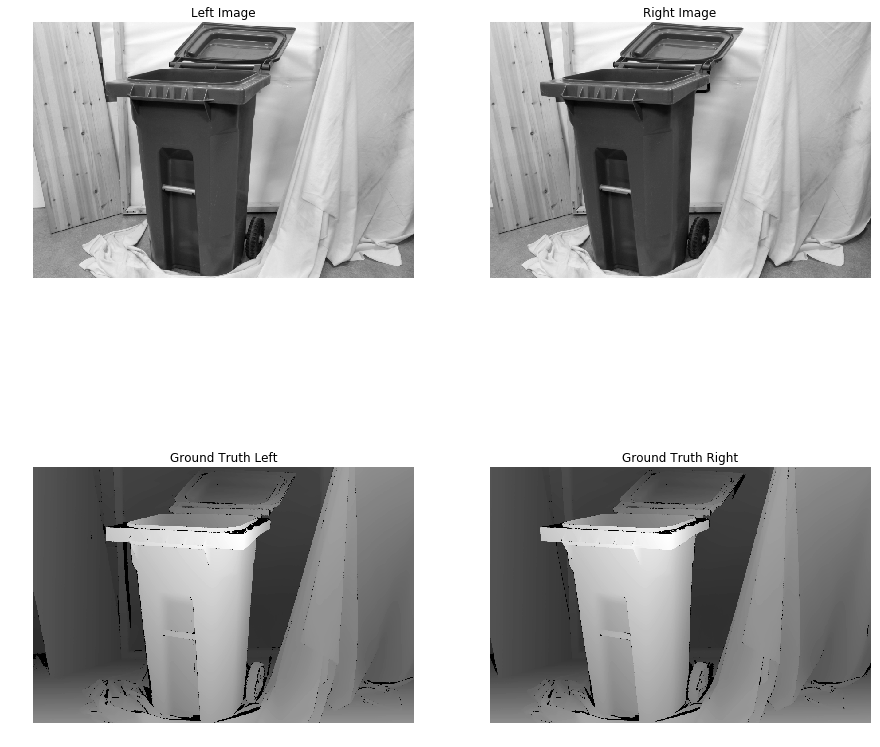

In [3]:
# Pair of images and depth maps used
# http://vision.middlebury.edu/stereo/data/scenes2014/datasets/Recycle-perfect/

# Read left and right stereo image-pair (in gray)
img_left = cv2.imread('./img_left.png', cv2.IMREAD_GRAYSCALE)
img_right = cv2.imread('./img_right.png', cv2.IMREAD_GRAYSCALE)

img_left = cv2.resize(img_left, None, fx=0.3, fy=0.3)
img_right = cv2.resize(img_right, None, fx=0.3, fy=0.3)

# Read left and right depth maps
dpm_left = readPFM('./dpm_left.pfm')
dpm_right = readPFM('./dpm_right.pfm')

dpm_left[dpm_left == np.inf] = 0
dpm_right[dpm_right == np.inf] = 0

dpm_left = cv2.resize(dpm_left, None, fx=0.3, fy=0.3)
dpm_right = cv2.resize(dpm_right, None, fx=0.3, fy=0.3)

# Display images 
plt.figure(figsize=(15, 15))
plt.subplot(221), plt.imshow(img_left, cmap='gray')
plt.title('Left Image'), plt.axis('off')
plt.subplot(222), plt.imshow(img_right, cmap='gray')
plt.title('Right Image'), plt.axis('off')
plt.subplot(223), plt.imshow(dpm_left, cmap='gray')
plt.title('Ground Truth Left'), plt.axis('off')
plt.subplot(224), plt.imshow(dpm_right, cmap='gray')
plt.title('Ground Truth Right'), plt.axis('off')
plt.show()

In [4]:
# Sample params
block_size = [5, 9, 15]
num_disparities = [16, 32, 48]

# Create depth map object
images = []
sbm = cv2.StereoBM_create()

# Loop through all test params
for bs in block_size:
    for disp in num_disparities:
        # Set blocksize and number of disparities
        sbm.setBlockSize(bs)
        sbm.setNumDisparities(disp)

        # Compute estimate and true depth maps
        depth = sbm.compute(img_left, img_right)
        ground = sbm.compute(dpm_left, dpm_right)
        
        # Compute SSD error
        sq_diff = (ground - depth) ** 2
        ssd = round(np.mean(sq_diff), 2)

        images.append({
            'title': 'Depth Map\nBlock Size {} - Disparity {}\nSSD Error {}'.format(bs, disp, ssd),
            'dpm': depth
        })

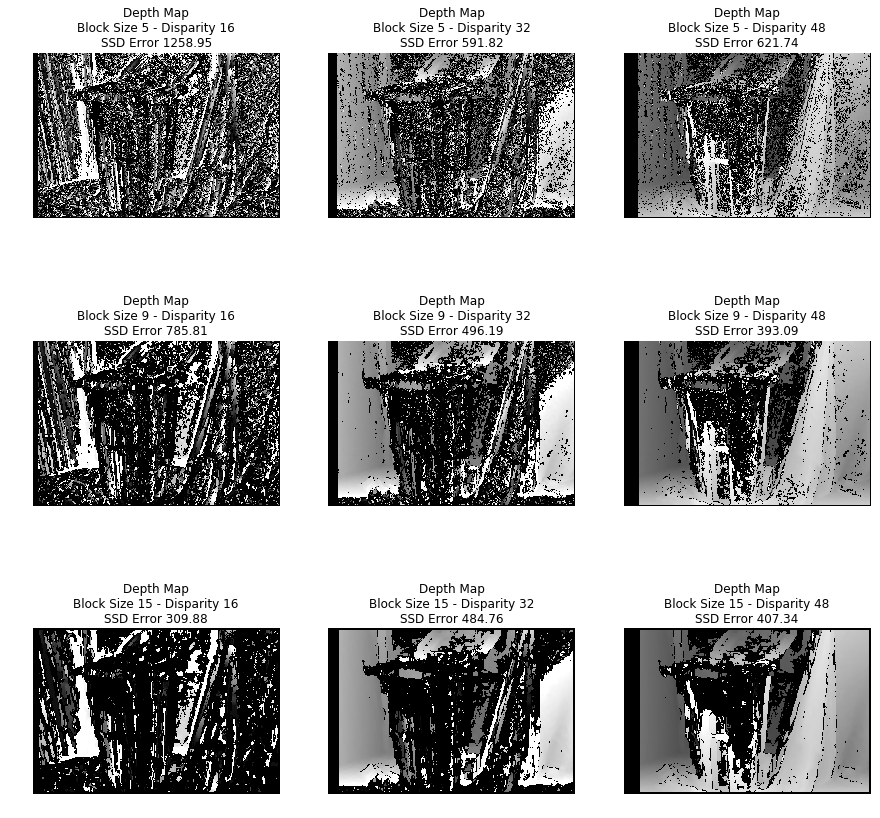

In [5]:
def plotDepth(images, size=3):
    """
    :param images: List of images to plot
    :param size: Width size of the grid
    """

    plt.figure(figsize=(15, 15))
    for i, image in enumerate(images, 1):
        plt.subplot(size, size, i), plt.imshow(image['dpm'], 'gray')
        plt.title(image['title']), plt.axis('off')
    plt.show()

plotDepth(images)

**Comment on the error-maps for each combination of parameters. Specifically, mention the effects of varying the parameters on the error in the region of high/low texture, edge, large/small depths.**

From the 9 figures above, we can see that increasing the number of disparity improves the depth in the image since it allows for better depth variations and sharper edges.

At the same time, increasing the block size smoothens the image and reduces the noise in the depth map which helps reduce the total SSD error. On the other hand, the computation of depth maps using smaller block sizes results in more detailed images